In [1]:
"""
error_analysis.py

This script performs error analysis on result JSON files generated by any of the approaches.
It uses the shared analyze_errors() function from factchecker_base.
"""

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import os
import re
import matplotlib
import itertools
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Save and Load Functions

In [2]:
def save_to_json(data, file_path):
    """
    Save a list of dictionaries to a JSON file.
    """
    try:
        with open(file_path, "w") as json_file:
            json.dump(data, json_file, indent=2)
        print(f"Data saved to {file_path}")
    except Exception as e:
        print(f"Error saving data to {file_path}: {e}")

def load_json(file_path):
    """
    Load a JSON file containing a list of dictionaries.
    """
    try:
        with open(file_path, "r") as json_file:
            data = json.load(json_file)
        return data
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return []


In [3]:
def accuracy(predictions):
    
    correct_predictions = sum(1 for p in predictions if p['true_response'] == p['predicted_response'])
    total_predictions = len(predictions)

    accuracy = (correct_predictions / total_predictions) * 100

    return (accuracy)

In [4]:
def load_accuracies_from_folder(folder_path):
    accuracies = []  # List to store accuracies
    filenames = []   # List to store the filenames
    
    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        if filename.startswith('results') and filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            # Load predictions from JSON file
            with open(file_path, 'r') as file:
                predictions = json.load(file)
                
                # Append accuracy and filename
                accuracies.append(accuracy(predictions))
                filenames.append(filename)
    
    return accuracies, filenames

# Example usage
folder_path = '../docs/results'  # Replace with the path to your folder
accuracies, filenames = load_accuracies_from_folder(folder_path)
sorted_accuracies, sorted_filenames = zip(*sorted(zip(accuracies, filenames), reverse=True))

# Print the accuracies and filenames
for acc, filename in zip(sorted_accuracies, sorted_filenames):
    print(f"Accuracy: {acc:.2f}%, Filename: {filename}")


Accuracy: 89.13%, Filename: results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_naturalized.json
Accuracy: 88.93%, Filename: results_with_cells_phi4:latest_test_examples_1695_zero_shot_naturalized.json
Accuracy: 88.79%, Filename: results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_markdown.json
Accuracy: 88.58%, Filename: results_with_cells_phi4:latest_test_examples_1695_zero_shot_markdown.json
Accuracy: 87.23%, Filename: results_with_cells_phi4:latest_test_examples_1695_zero_shot_json.json
Accuracy: 86.30%, Filename: results_with_cells_phi4:latest_test_examples_1695_zero_shot_html.json
Accuracy: 86.11%, Filename: results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_html.json
Accuracy: 85.84%, Filename: results_with_cells_deepseek-r1:32b_test_examples_973_zero_shot_naturalized.json
Accuracy: 85.77%, Filename: results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_json.json
Accuracy: 85.63%, Filename: results_with_cells_deepseek-r1

In [44]:
folder_path = 'results_20250212'  # Replace with the path to your folder
accuracies, filenames = load_accuracies_from_folder(folder_path)
sorted_accuracies, sorted_filenames = zip(*sorted(zip(accuracies, filenames), reverse=True))

# Print the accuracies and filenames
for acc, filename in zip(sorted_accuracies, sorted_filenames):
    print(f"Accuracy: {acc:.2f}%, Filename: {filename}")

Accuracy: 81.85%, Filename: results_CodeGeneration_test_examples_zero_shot_naturalized_phi4.json


In [45]:
def top_10_accuracies(accuracies, filenames):
    # Combine accuracies and filenames into a list of tuples
    accuracy_filename_pairs = list(zip(accuracies, filenames))
    
    # Sort the list by accuracy in descending order
    sorted_accuracy_filename_pairs = sorted(accuracy_filename_pairs, key=lambda x: x[0], reverse=True)
    
    # Get the top 10 accuracies and filenames
    top_10 = sorted_accuracy_filename_pairs[:10]
    
    # Separate the top 10 accuracies and filenames
    top_10_accuracies = [pair[0] for pair in top_10]
    top_10_filenames = [pair[1] for pair in top_10]
    
    return top_10_accuracies, top_10_filenames

# Example usage
top_10_accuracies_list, top_10_filenames_list = top_10_accuracies(accuracies, filenames)

# Print the results
print("Top 10 Accuracies:")
for acc, name in zip(top_10_accuracies_list, top_10_filenames_list):
    print(f"{name}: {acc:.2f}%")

Top 10 Accuracies:
results_CodeGeneration_test_examples_zero_shot_naturalized_phi4.json: 81.85%


In [46]:
def transform_filenames(filenames):
    transformed_filenames = []

    # Define the pattern to match the unwanted parts of the filename
    pattern = r"results_with_cells[:]?([\w\-]+)(?:[:]\w+)?_test_examples_\d+_(.*)\.json"

    # Iterate through each filename and apply the transformation
    for filename in filenames:
        match = re.match(pattern, filename)
        if match:
            model = match.group(1).lstrip('_')  # Remove the leading underscore from the model
            prompt_engineering = match.group(2)  # Extract the prompt engineering part
            transformed_filename = f"{model} {prompt_engineering.replace('_', ' ')}"
            transformed_filenames.append(transformed_filename)
        else:
            # If the filename does not match the expected pattern, append it as is
            transformed_filenames.append(filename)

    return transformed_filenames



top_10_filenames_list = transform_filenames(top_10_filenames_list)
for f in top_10_filenames_list:
    print(f)

results_CodeGeneration_test_examples_zero_shot_naturalized_phi4.json


In [47]:
def load_top_10_files(accuracies, filenames, folder_path):
    # Get the top 10 accuracies and corresponding filenames
    top_10_accuracies_list, top_10_filenames_list = top_10_accuracies(accuracies, filenames)
    
    top_10_files_data = []  # List to store the data of the top 10 files

    # Load the predictions from each of the top 10 files
    for filename in top_10_filenames_list:
        file_path = os.path.join(folder_path, filename)
        
        # Open the JSON file and load its content into a list of dictionaries
        with open(file_path, 'r') as file:
            file_data = json.load(file)
            top_10_files_data.append(file_data)
    
    return top_10_files_data

# Example usage
top_10_files_data = load_top_10_files(accuracies, filenames, folder_path)

# Plot Functions

## Plot Misclassifications per categories

In [5]:
def calculate_misclassifications(predictions, categorised_claims, category_misclassifications):
    """
    Calculates the misclassification percentage for each category, based on the new structure where
    true_response is in the predictions. Also handles claims that fall under "no category."

    Args:
    - predictions (list of dicts): Predictions made by the model.
    - categorised_claims (list of dicts): Claims categorized under different labels.

    Returns:
    - dict: A dictionary with categories as keys and misclassification percentages as values.
    """
    # Initialize counters for total claims and misclassifications per category
    category_counts = {category: 0 for category in category_misclassifications}
    category_misclassifications = {category: 0 for category in category_misclassifications}

    # Add the "no category" entry
    category_counts["no category"] = 0
    category_misclassifications["no category"] = 0

    for prediction in predictions:
        claim = prediction["claim"]
        true_response = prediction["true_response"]
        predicted_response = prediction["predicted_response"]
        
        # Find the claim in the categorised_claims
        claim_data = next((item for item in categorised_claims if item["claim"] == claim), None)
        
        # If the claim is categorized, check the categories
        if claim_data:
            is_misclassified = true_response != predicted_response

            # Track the claim for the categories it belongs to
            classified = False
            for category in category_counts:
                if category in claim_data and claim_data[category]:
                    classified = True
                    category_counts[category] += 1
                    if is_misclassified:
                        category_misclassifications[category] += 1

            # If the claim is not categorized under any category, classify as "no category"
            if not classified:
                category_counts["no category"] += 1
                if is_misclassified:
                    category_misclassifications["no category"] += 1
        else:
            # If the claim is not found in the categorised claims, classify as "no category"
            category_counts["no category"] += 1
            if true_response != predicted_response:
                category_misclassifications["no category"] += 1

    # Calculate the percentage of misclassifications for each category
    category_percentages = {
        category: (category_misclassifications[category] / category_counts[category] * 100)
        if category_counts[category] > 0 else 0
        for category in category_counts
    }

    return category_percentages

In [6]:
def plot_misclassifications(category_percentages):
    """
    Plots the misclassification percentages for each category.

    Args:
    - category_percentages (dict): A dictionary with categories as keys and misclassification percentages as values.
    """
    categories = list(category_percentages.keys())
    percentages = list(category_percentages.values())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(categories, percentages, color='r')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Percentage (%)')
    ax.set_title('Misclassification Percentage per Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_misclassifications_with_overall_misclassification(category_percentages, predictions):
    """
    Plots the misclassification percentages for each category and adds a dashed horizontal line 
    representing the overall accuracy of the classifications.

    Args:
    - category_percentages (dict): A dictionary with categories as keys and misclassification percentages as values.
    - predictions (list of dicts): Predictions made by the model.
    """
    categories = list(category_percentages.keys())
    percentages = list(category_percentages.values())

    # Compute overall accuracy
    total_predictions = len(predictions)
    total_misclassifications = sum(1 for p in predictions if p["true_response"] != p["predicted_response"])
    overall_accuracy = total_misclassifications / total_predictions * 100

    # Plot histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(categories, percentages, color='r', alpha=0.7, label='Misclassification %')

    # Add horizontal line for overall accuracy
    ax.axhline(y=overall_accuracy, color='b', linestyle='dashed', linewidth=2, label=f'Overall Misclassification Rate: {overall_accuracy:.2f}%')

    # Labels and title
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Percentage (%)')
    ax.set_title('Misclassification Percentage per Category')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot category co-occurences

In [8]:
def plot_category_cooccurrence(categorised_claims):
    # Extract all unique categories
    categories = set()
    for claim in categorised_claims:
        categories.update(claim.keys())
    categories.discard("ID")  # Remove non-category fields
    categories.discard("claim")
    
    # Initialize co-occurrence matrix
    category_list = sorted(categories)
    cooccurrence_matrix = pd.DataFrame(0, index=category_list, columns=category_list)
    
    # Populate co-occurrence matrix
    for claim in categorised_claims:
        active_categories = [cat for cat in category_list if claim.get(cat, False)]
        for i in range(len(active_categories)):
            for j in range(i, len(active_categories)):
                cooccurrence_matrix.loc[active_categories[i], active_categories[j]] += 1
                if i != j:
                    cooccurrence_matrix.loc[active_categories[j], active_categories[i]] += 1
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title("Category Co-occurrence Heatmap")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

## Count claims per categories

In [9]:
from collections import defaultdict

def count_claims_per_category(categorised_claims):
    # Initialize a defaultdict to store counts for each category
    category_counts = defaultdict(int)
    
    # Loop through each claim in categorised_claims
    for claim_data in categorised_claims:
        # Track if the claim belongs to at least one category
        claim_belongs_to_category = False
        
        # Loop through each key in the claim (excluding ID and claim text)
        for category, is_present in claim_data.items():
            # Only count if the category is a boolean and is True
            if category != "ID" and category != "claim" and is_present:
                category_counts[category] += 1
                claim_belongs_to_category = True
        
        # If claim doesn't belong to any category, count it under "no category"
        if not claim_belongs_to_category:
            category_counts["no category"] += 1
    
    return category_counts

import matplotlib.pyplot as plt

def plot_category_counts(category_counts):
    # Create a bar plot for category counts
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    
    # Create the bar plot
    bars = plt.bar(categories, counts, color='skyblue')
    
    # Add labels and title
    plt.xlabel('Categories')
    plt.ylabel('Number of Claims')
    plt.title('Number of Claims per Category')
    plt.xticks(rotation=45, ha="right")
    
    # Annotate each bar with the count value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, str(yval), ha='center', va='bottom')
    
    # Calculate the dynamic y-axis limit (1.3 times the maximum value)
    y_max = max(counts) * 1.3
    
    # Set y-axis range dynamically
    plt.ylim(0, y_max)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## Assess performance of multiple models (here)

In [34]:
from numpy import pad


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["pdf.fonttype"] = 42   # Ensures fonts are embedded in the PDF
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.dpi"] = 300    # High DPI for sharper visuals
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
# Use a distinct color cycle (tab10) instead of default
# plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)

def plot_comparison(model_errors_list, accuracy_list, model_names, output_pdf="histogram_PromptEngineering.pdf"):
    """
    Creates a comparative bar chart of misclassification rates across multiple models and categories.
    
    Args:
        model_errors_list (list[dict]): A list of dictionaries, each mapping categories to misclassification rates.
        accuracy_list (list[float]): A list of accuracies corresponding to each model.
        model_names (list[str]): A list of model names.
        output_pdf (str): Filename for saving the output PDF.
    """
    
    # --- Prepare data ---
    # Assume all models share the same category keys
    categories = list(model_errors_list[0].keys())
    
    # Remove underscores, replace them with line breaks, and convert to Title Case
    formatted_categories = [cat.replace('_', '\n').title() for cat in categories]
    
    # Use a scaling factor to create more space between groups
    spacing_factor = 1.1  # Increase this value to add more space between groups

    x = np.arange(len(categories)) * spacing_factor  # Adds space between groups
    # Increase bar width for better visibility
    width = 0.9 / len(model_errors_list)

    # Collect all values for a dynamic y-limit
    all_values = []
    for model_errors in model_errors_list:
        all_values.extend(model_errors.values())
    y_max = max(all_values) * 1.4

    # --- Create figure & axis ---
    # Slightly wider figure to accommodate wider bars
    fig, ax = plt.subplots(figsize=(8.5, 5))

    # --- Plot bars ---
    for i, (model_errors, accuracy, model_name) in enumerate(zip(model_errors_list, accuracy_list, model_names)):
        model_values = list(model_errors.values())
        
        # Position bars side by side
        bars = ax.bar(
            x + i * width - (width * (len(model_errors_list) - 1)) / 2,
            model_values,
            width,
            label=f'{model_name} (Accuracy: {accuracy:.2f}%)'
        )
        
        # Add numerical labels above each bar (no '%' sign, minimal offset)
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01 * y_max,  # small offset
                f'{height:.1f}',       # removed '%'
                ha='center',
                va='bottom',
                fontsize=9
            )

    # --- Axis labels (no title as requested) ---
    ax.set_xlabel('Categories', fontsize=11)
    ax.set_ylabel('Misclassification Rate (%)', fontsize=11)

    ax.set_xticks(x)
    # No rotation; text is line-broken instead
    ax.set_xticklabels(formatted_categories, rotation=0, ha='center', fontsize=10)
    
    # Set y-axis range
    ax.set_ylim(0, y_max)

    # --- Legend placement: above the plot area, centered ---
    ax.legend(
        fontsize=9,
        loc='upper center',
        bbox_to_anchor=(0.5, 1),  # Move legend above the axes
        fancybox=True,
        shadow=False,
        ncol=2
    )
    
    # Adjust subplot so legend/title do not overlap bars
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.12, right=0.95)

    # --- Save & show ---
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()


## Heatmap of model performances

In [54]:
def calculate_category_combinations_misclassification(categorised_claims, predictions):
    # Initialize a dictionary to hold misclassification counts for each category combination
    category_combinations = defaultdict(lambda: {'total': 0, 'misclassified': 0})
    
    # Iterate through each prediction
    for prediction in predictions:
        claim_text = prediction['claim']
        true_response = prediction['true_response']
        predicted_response = prediction['predicted_response']
        
        # Find the matching claim in categorised_claims
        claim_data = next((item for item in categorised_claims if item['claim'] == claim_text), None)
        
        if claim_data:
            # Get the categories the claim falls under
            categories = [category for category, is_present in claim_data.items() if category != 'ID' and category != 'claim' and is_present]
            
            # Generate all combinations of categories the claim belongs to
            category_combinations_list = []
            for i in range(1, len(categories) + 1):
                category_combinations_list.extend(itertools.combinations(categories, i))
            
            # For each combination, track the misclassification
            for category_combination in category_combinations_list:
                combination_key = tuple(sorted(category_combination))  # Sort the combination to avoid duplication
                category_combinations[combination_key]['total'] += 1
                if true_response != predicted_response:
                    category_combinations[combination_key]['misclassified'] += 1
    
    # Calculate the misclassification rates for each combination
    misclassification_rates = {}
    for combination, counts in category_combinations.items():
        total_claims = counts['total']
        misclassified_claims = counts['misclassified']
        misclassification_rate = (misclassified_claims / total_claims) * 100 if total_claims > 0 else 0
        misclassification_rates[combination] = misclassification_rate
    
    # Return a list of lists of misclassification rates
    category_labels = list(misclassification_rates.keys())
    misclassification_values = list(misclassification_rates.values())
    
    # Prepare the data in a format suitable for a heatmap
    unique_categories = sorted(set(itertools.chain(*category_labels)))
    heatmap_data = np.zeros((len(unique_categories), len(unique_categories)))
    
    # Map combinations to indices in the heatmap
    category_index_map = {category: idx for idx, category in enumerate(unique_categories)}
    
    for combination, rate in misclassification_rates.items():
        x_idx = category_index_map[combination[0]]
        y_idx = category_index_map[combination[1]] if len(combination) > 1 else x_idx
        heatmap_data[x_idx][y_idx] = rate
        if x_idx != y_idx:
            heatmap_data[y_idx][x_idx] = rate  # Ensure symmetry in the heatmap
    
    return heatmap_data, unique_categories


In [55]:
def plot_category_combinations_heatmap(heatmap_data, unique_categories):
    # Create a DataFrame from the heatmap data for seaborn
    import pandas as pd
    heatmap_df = pd.DataFrame(heatmap_data, index=unique_categories, columns=unique_categories)

    # Create the heatmap plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={'label': 'Misclassification Rate (%)'})

    # Add labels and title
    plt.title('Heatmap of Misclassification Rates per Category Combination')
    plt.xlabel('Category Combinations')
    plt.ylabel('Category Combinations')
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [70]:
def plot_multiple_models_heatmap(list_of_predictions, accuracies, list_of_predictions_names, categorised_claims):
    """
    Plots a heatmap matrix (one row) for multiple models, showing misclassification rates per category combination.
    
    Args:
    - list_of_predictions: List of lists of dictionaries, each representing predictions for a given model.
    - accuracies: List of accuracy values corresponding to each model.
    - list_of_predictions_names: List of names of models to use as labels.
    - categorised_claims: The list of categorised claims to compute misclassification rates.
    """
    heatmaps = []
    unique_categories = None  # Store unique categories once

    # Generate heatmap data for each model
    for predictions in list_of_predictions:
        heatmap_data, unique_categories = calculate_category_combinations_misclassification(categorised_claims, predictions)
        heatmaps.append(heatmap_data)

    # Convert list of heatmaps into a 3D numpy array (models × categories × categories)
    heatmap_matrix = np.array(heatmaps)

    # Define custom colormap (gray to red)
    custom_cmap = LinearSegmentedColormap.from_list("gray_to_red", ["lightgray", "#B22222"])

    # Create a single-row figure
    fig, axes = plt.subplots(1, len(list_of_predictions), figsize=(5 * len(list_of_predictions), 8))

    # Ensure axes is iterable (handles single model case)
    if len(list_of_predictions) == 1:
        axes = [axes]

    # Plot heatmap for each model
    for ax, heatmap_data, model_name, accuracy in zip(axes, heatmap_matrix, list_of_predictions_names, accuracies):
        heatmap_df = pd.DataFrame(heatmap_data, index=unique_categories, columns=unique_categories)
        sns.heatmap(heatmap_df, annot=True, cmap=custom_cmap, fmt=".1f", cbar=False, ax=ax)

        # Add model name and accuracy to title
        ax.set_title(f"{model_name}\nAccuracy: {accuracy:.2f}%", fontsize=15)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45, fontsize=12)

        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [57]:
def plot_multiple_models_heatmap_2by2(list_of_predictions, accuracies, list_of_predictions_names, categorised_claims):
    """
    Plots a heatmap matrix (2x2 grid) for multiple models, showing misclassification rates per category combination.
    
    Args:
    - list_of_predictions: List of lists of dictionaries, each representing predictions for a given model.
    - accuracies: List of accuracy values corresponding to each model.
    - list_of_predictions_names: List of names of models to use as labels.
    - categorised_claims: The list of categorised claims to compute misclassification rates.
    """
    heatmaps = []
    unique_categories = None  # Store unique categories once

    # Generate heatmap data for each model
    for predictions in list_of_predictions:
        heatmap_data, unique_categories = calculate_category_combinations_misclassification(categorised_claims, predictions)
        heatmaps.append(heatmap_data)

    # Convert list of heatmaps into a 3D numpy array (models × categories × categories)
    heatmap_matrix = np.array(heatmaps)

    # Define custom colormap (gray to red)
    custom_cmap = LinearSegmentedColormap.from_list("gray_to_red", ["lightgray", "#B22222"])

    # Create a 2x2 grid figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten axes array to make it iterable
    axes = axes.flatten()

    # Plot heatmap for each model
    for ax, heatmap_data, model_name, accuracy in zip(axes, heatmap_matrix, list_of_predictions_names, accuracies):
        heatmap_df = pd.DataFrame(heatmap_data, index=unique_categories, columns=unique_categories)
        sns.heatmap(heatmap_df, annot=True, cmap=custom_cmap, fmt=".1f", cbar=False, ax=ax)

        # Add model name and accuracy to title
        ax.set_title(f"{model_name}\nAccuracy: {accuracy:.2f}%", fontsize=12)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout and show
    plt.tight_layout()
    plt.show()


# Plot

In [11]:
predictions_file_name = "../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_html.json"
predictions = load_json(predictions_file_name)

In [12]:
their_categorised_claims_file_name = "Error_Analysis/categorised_claims_mistral.json"
their_categorised_claims = load_json(their_categorised_claims_file_name)

our_categorised_claims_file_name = "Error_Analysis/our_category_claims_mistral.json"
our_categorised_claims = load_json(our_categorised_claims_file_name)

our_categorised_claims_bis_file_name = "Error_Analysis/our_category_claims_bis_mistral.json"
our_categorised_claims_bis = load_json(our_categorised_claims_bis_file_name)

their_category_misclassifications = { 
        "all": 0, "none": 0, "negate": 0, "comparative": 0, 
        "ordinal": 0, "unique": 0, "superlative": 0, "aggregation": 0
    }

our_category_misclassifications = {
    "single_attribute_verification": 0,
    "negation_absence_check": 0,
    "numerical_threshold_check": 0,
    "aggregation_computation": 0,
    "record_existence": 0,
    "comparative_analysis": 0,
    "conditional_logic": 0
    }

our_category_misclassifications_bis = {
    "unclear_or_noisy_language": 0,
    "numerical_reasoning": 0,
    "multistep_logic": 0,
    "negation": 0
}

### their categories

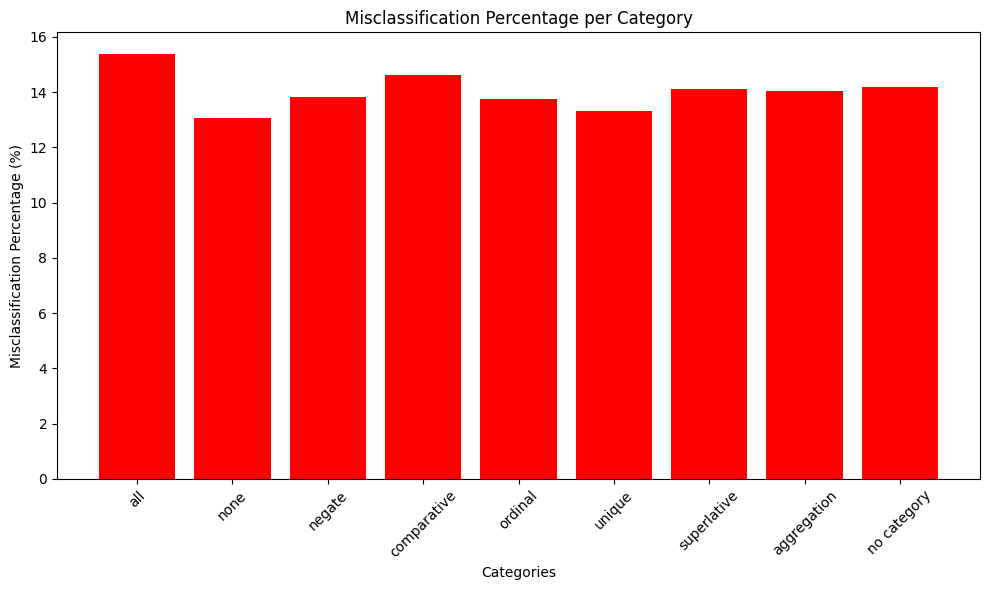

In [60]:
category_percentages = calculate_misclassifications(predictions, their_categorised_claims, their_category_misclassifications)
plot_misclassifications(category_percentages)

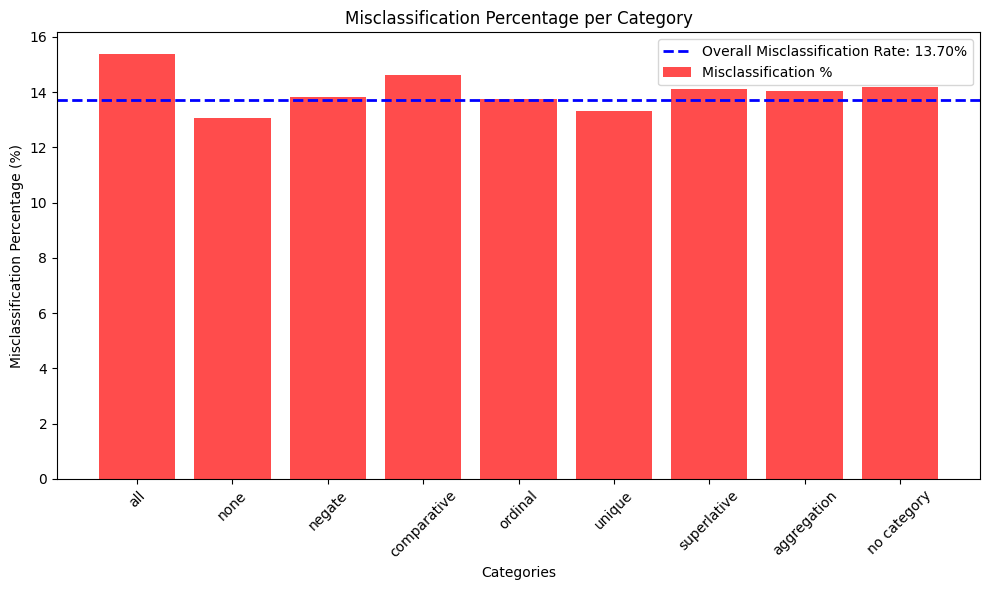

In [61]:
plot_misclassifications_with_overall_misclassification(predictions=predictions, category_percentages=category_percentages)

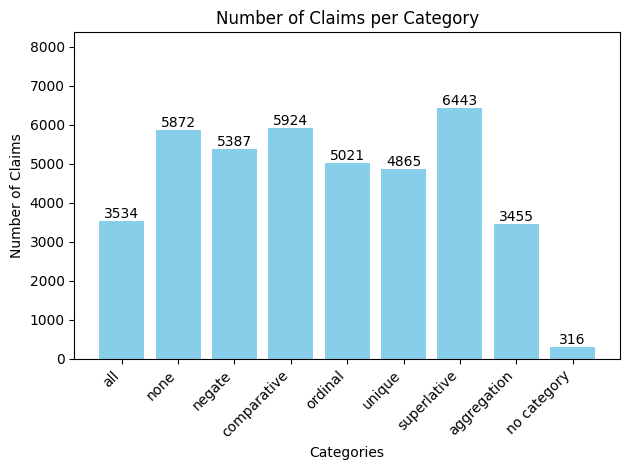

In [62]:
category_counts = count_claims_per_category(their_categorised_claims)
plot_category_counts(category_counts)

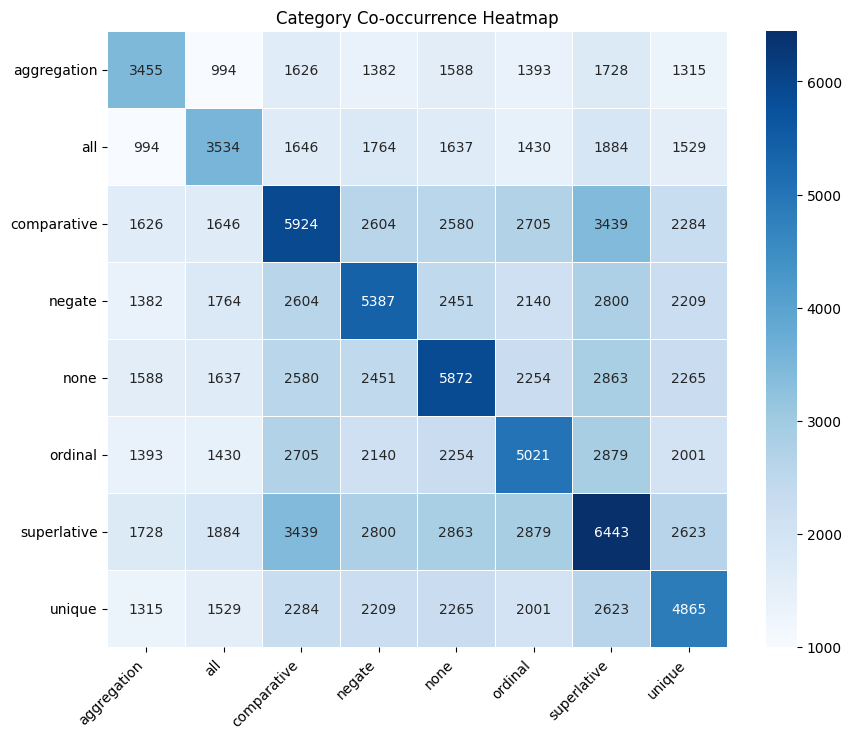

In [63]:
plot_category_cooccurrence(their_categorised_claims)

### OUR CATEGORIES

In [ ]:
category_percentages = calculate_misclassifications(predictions, our_categorised_claims, our_category_misclassifications)
plot_misclassifications_with_overall_misclassification(predictions=predictions, category_percentages=category_percentages)

In [ ]:
misclassifications = [calculate_misclassifications(predictions, our_categorised_claims, our_category_misclassifications) for predictions in list_of_predictions]
plot_comparison(misclassifications, accuracies, list_of_predictions_names)

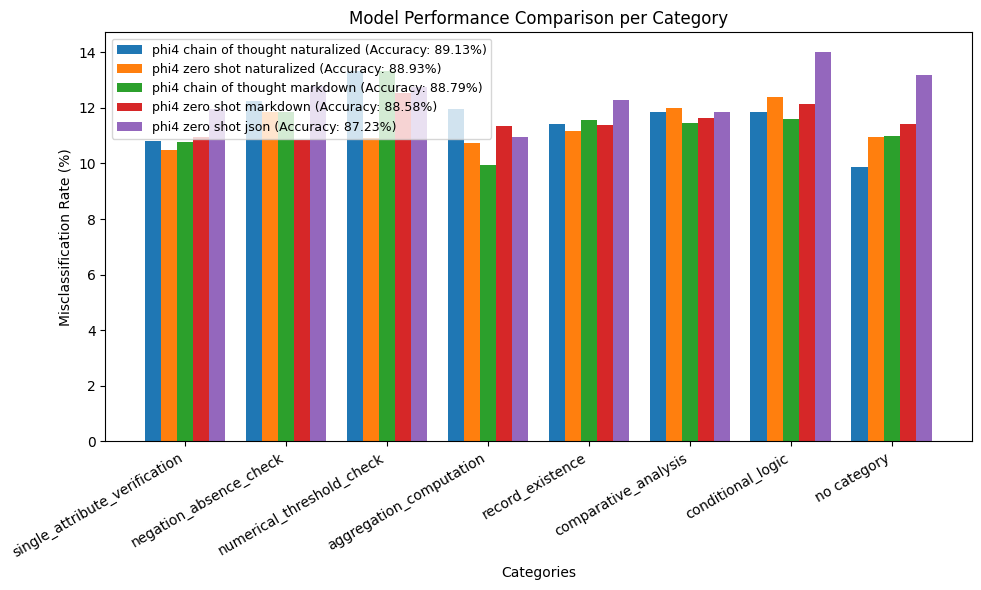

In [ ]:
predictions_file_names = [
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_naturalized.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_naturalized.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_markdown.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_markdown.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_json.json'
]

list_of_predictions = [load_json(predictions_file) for predictions_file in predictions_file_names]

list_of_predictions_names = [
'phi4 chain of thought naturalized',
'phi4 zero shot naturalized',
'phi4 chain of thought markdown',
'phi4 zero shot markdown',
'phi4 zero shot json',
]

accuracies = [accuracy(predictions) for predictions in list_of_predictions]
misclassifications = [calculate_misclassifications(predictions, our_categorised_claims, our_category_misclassifications) for predictions in list_of_predictions]
plot_comparison(misclassifications, accuracies, list_of_predictions_names)

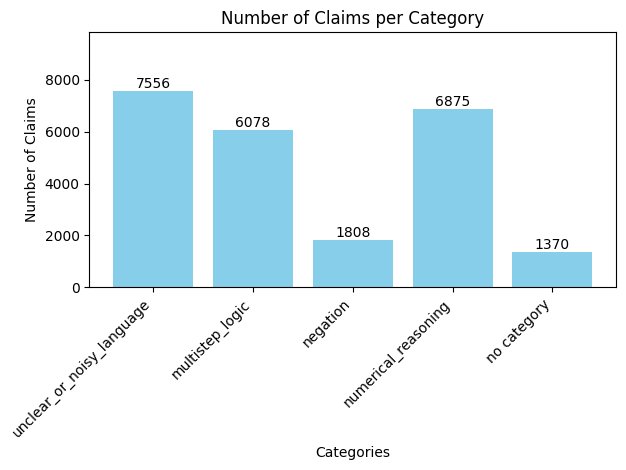

In [ ]:
category_counts = count_claims_per_category(our_categorised_claims_bis)
plot_category_counts(category_counts)

### OUR CATEGORIES BIS

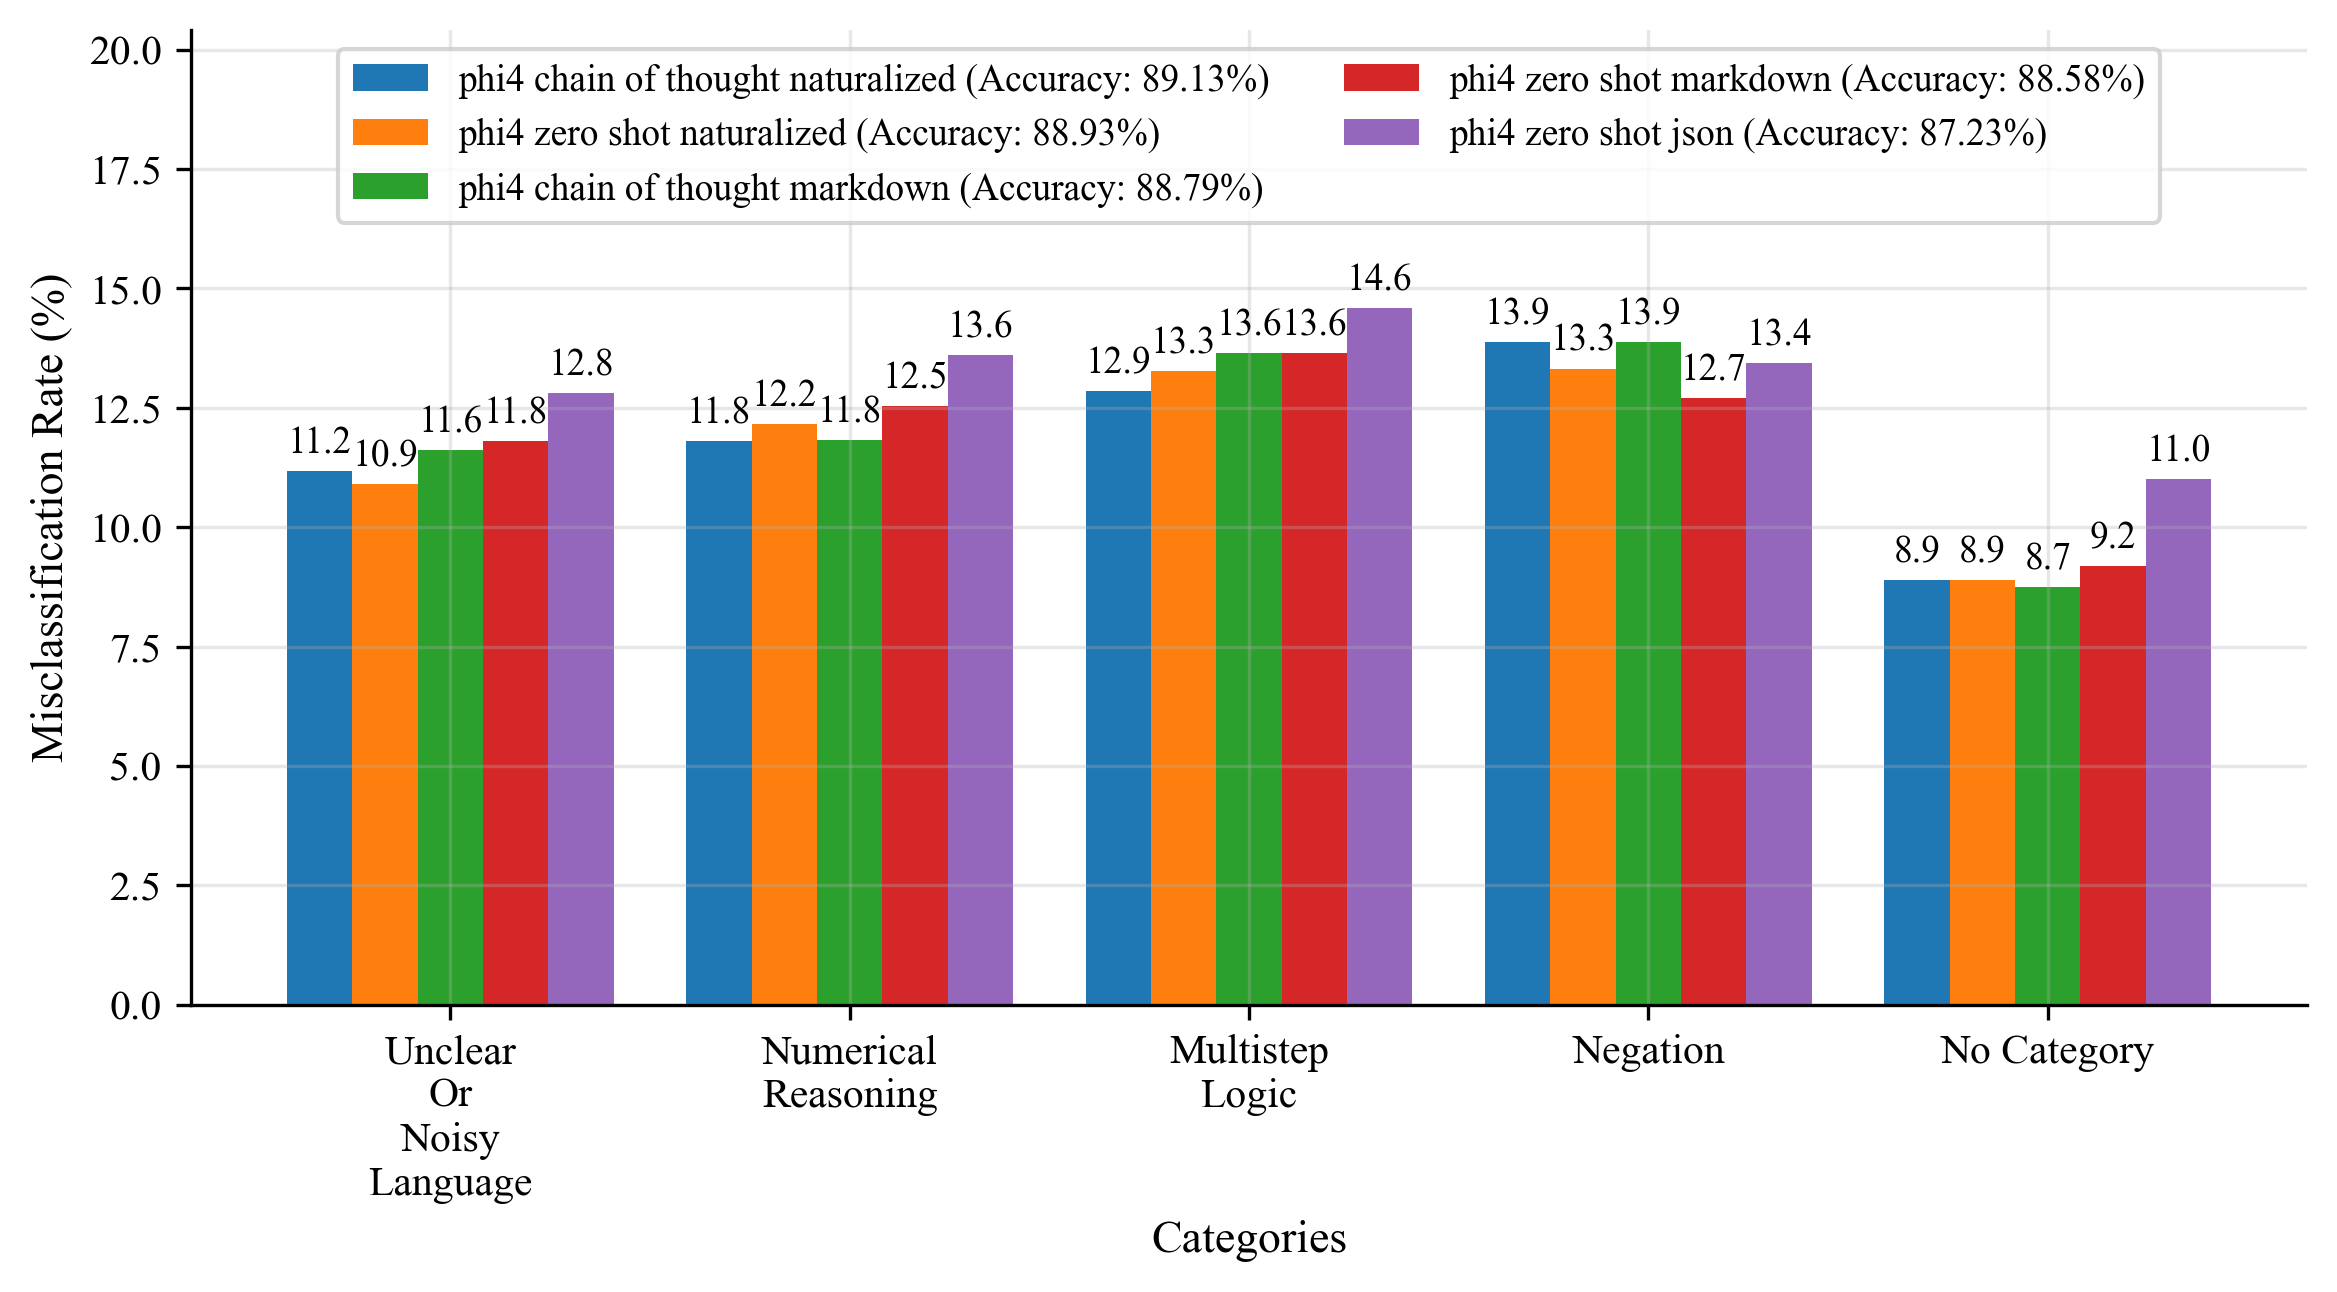

In [35]:
predictions_file_names = [
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_naturalized.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_naturalized.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_markdown.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_markdown.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_json.json'
]

list_of_predictions = [load_json(predictions_file) for predictions_file in predictions_file_names]

list_of_predictions_names = [
'phi4 chain of thought naturalized',
'phi4 zero shot naturalized',
'phi4 chain of thought markdown',
'phi4 zero shot markdown',
'phi4 zero shot json',
]

accuracies = [accuracy(predictions) for predictions in list_of_predictions]
misclassifications = [calculate_misclassifications(predictions, our_categorised_claims_bis, our_category_misclassifications_bis) for predictions in list_of_predictions]
plot_comparison(misclassifications, accuracies, list_of_predictions_names)

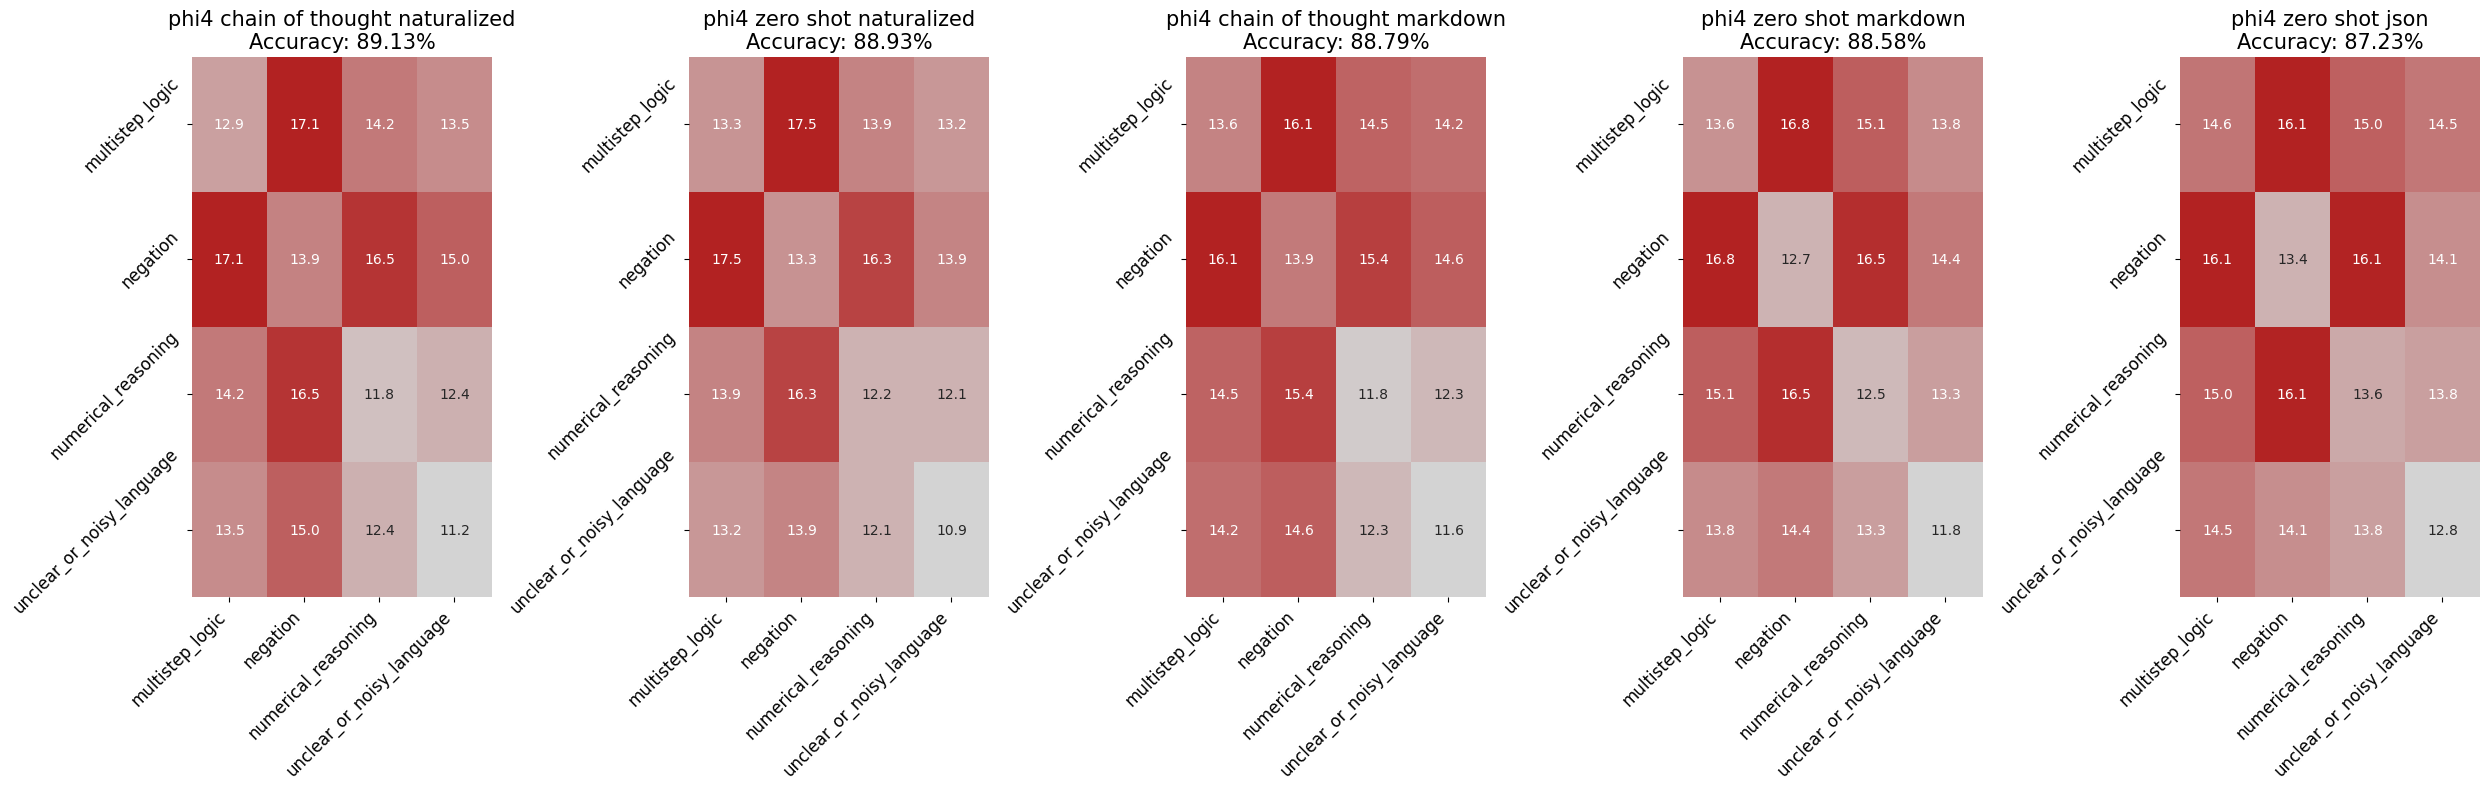

In [71]:
plot_multiple_models_heatmap(list_of_predictions, accuracies, list_of_predictions_names, our_categorised_claims_bis)

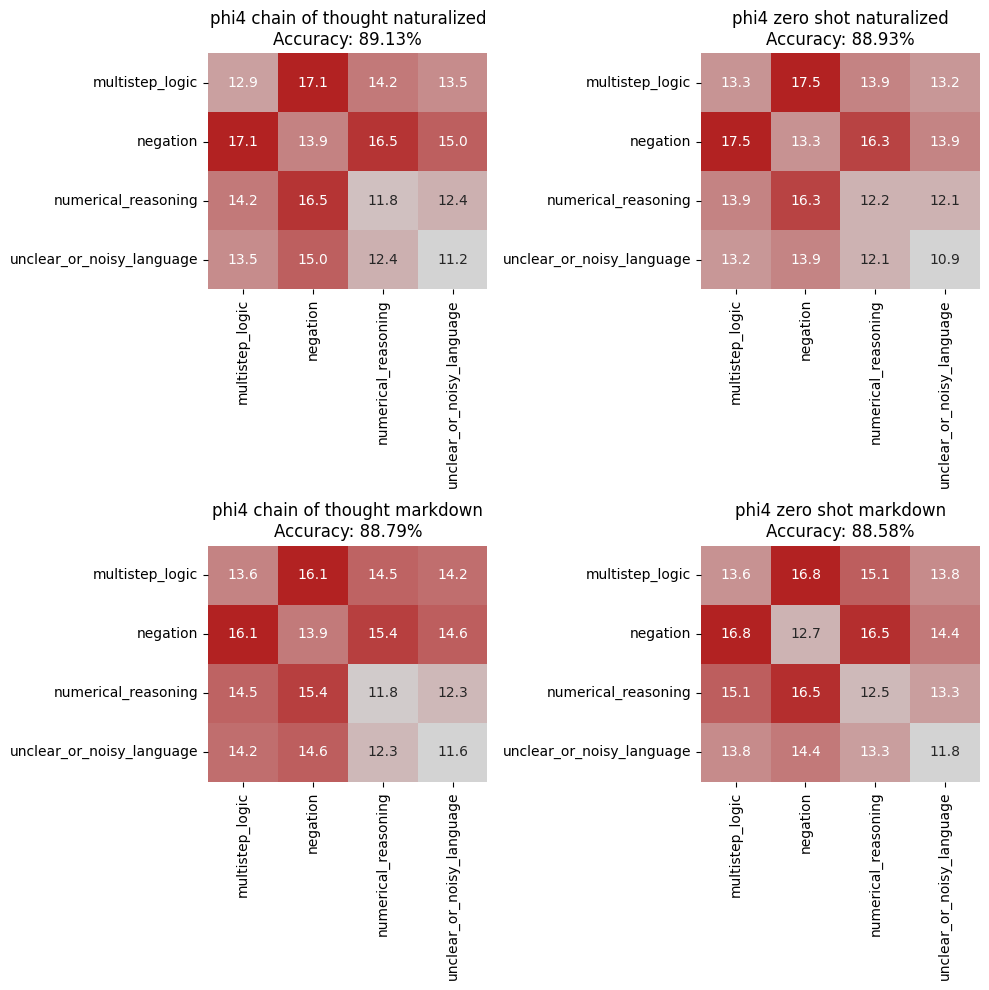

In [67]:
plot_multiple_models_heatmap_2by2(list_of_predictions, accuracies, list_of_predictions_names, our_categorised_claims_bis)

In [ ]:
predictions_file_names = [
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_naturalized.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_naturalized.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_chain_of_thought_markdown.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_markdown.json',
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_json.json'
]

list_of_predictions = [load_json(predictions_file) for predictions_file in predictions_file_names]

list_of_predictions_names = [
'phi4 chain of thought naturalized',
'phi4 zero shot naturalized',
'phi4 chain of thought markdown',
'phi4 zero shot markdown',
'phi4 zero shot json',
]

accuracies = [accuracy(predictions) for predictions in list_of_predictions]
misclassifications = [calculate_misclassifications(predictions, our_categorised_claims_bis, our_category_misclassifications_bis) for predictions in list_of_predictions]
plot_comparison(misclassifications, accuracies, list_of_predictions_names)

# Helper functions

In [ ]:
def split_claims(claims_list):
    misclassified = []
    correctly_classified = []

    for claim_data in claims_list:
        if claim_data["predicted_response"] != claim_data["true_response"]:
            misclassified.append(claim_data["claim"])
        else:
            correctly_classified.append(claim_data["claim"])

    return misclassified[:50], correctly_classified[:50]

# Example usage
misclassified_claims, correctly_classified_claims = split_claims(predictions_1)
for m in misclassified_claims:
    print(m)
    print()


print("\n\nHere are correctly classified claims:\n\n")

for c in correctly_classified_claims:
    print(c)
    print()

In [27]:
def find_files_with_max_elements(path_name):
    max_elements = 0
    files_with_max_elements = []

    # Iterate through all files in the folder
    for filename in os.listdir(path_name):
        if filename.endswith('.json'):
            file_path = os.path.join(path_name, filename)
            
            # Open the JSON file and load its content
            with open(file_path, 'r') as file:
                data = json.load(file)
                
                # Check the number of objects (elements) in the list
                num_elements = len(data)
                
                # Update max_elements and the corresponding filenames
                if num_elements > max_elements:
                    max_elements = num_elements
                    files_with_max_elements = [filename]
                elif num_elements == max_elements:
                    files_with_max_elements.append(filename)

    return files_with_max_elements

# Example usage
path_name = '../docs/results'  # Replace with the path to your folder
files = find_files_with_max_elements(path_name)
print("Files with the maximum number of elements:")
for file in files:
    print(file)

Files with the maximum number of elements:
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_html.json
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_markdown.json
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_naturalized.json
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_json.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_html.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_json.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_markdown.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_naturalized.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_html.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_json.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_markdown.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_naturalized.json
results_with_cel